##  Librerías

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import classification_report

##  Directorios

In [4]:
# Directorio principal
directorio_dataset = '/content/dataset/'
directorio_benigno = os.path.join(directorio_dataset, 'benigno')
directorio_maligno = os.path.join(directorio_dataset, 'maligno')
os.makedirs(directorio_benigno, exist_ok=True)
os.makedirs(directorio_maligno, exist_ok=True)

# Directorio train
directorio_train = '/content/train'
directorio_train_benigno = os.path.join(directorio_train, 'benigno')
directorio_train_maligno = os.path.join(directorio_train, 'maligno')
os.makedirs(directorio_train_benigno, exist_ok=True)
os.makedirs(directorio_train_maligno, exist_ok=True)

# Directorio test
directorio_test = '/content/test'
directorio_test_benigno = os.path.join(directorio_test, 'benigno')
directorio_test_maligno = os.path.join(directorio_test, 'maligno')
os.makedirs(directorio_test_benigno, exist_ok=True)
os.makedirs(directorio_test_maligno, exist_ok=True)

## Split, train, test

In [5]:
# Listas de rutas y etiquetas
ruta = []
etiqueta = []

# Split imágenes de directorio "Benigno" en train y test
imagenes_benigno = os.listdir(directorio_benigno)
benigno_train, benigno_test = train_test_split(imagenes_benigno, test_size=0.2, random_state=42)

# Mueve imágenes de directorio "Benigno" a directorios train y test
for imagen in benigno_train:
    origen = os.path.join(directorio_benigno, imagen)
    destino = os.path.join(directorio_train_benigno, imagen)
    shutil.copy(origen, destino)
    ruta.append(destino)
    etiqueta.append(destino.split(os.path.sep)[-2])

for imagen in benigno_test:
    origen = os.path.join(directorio_benigno, imagen)
    destino = os.path.join(directorio_test_benigno, imagen)
    shutil.copy(origen, destino)
    ruta.append(destino)
    etiqueta.append(destino.split(os.path.sep)[-2])

# Split imágenes de directorio "Maligno" en train y test
imagenes_maligno = os.listdir(directorio_maligno)
maligno_train, maligno_test = train_test_split(imagenes_maligno, test_size=0.2, random_state=42)

# Mueve imágenes de directorio "Maligno" a directorios train y test
for imagen in maligno_train:
    origen = os.path.join(directorio_maligno, imagen)
    destino = os.path.join(directorio_train_maligno, imagen)
    shutil.copy(origen, destino)
    ruta.append(destino)
    etiqueta.append(destino.split(os.path.sep)[-2])

for imagen in maligno_test:
    origen = os.path.join(directorio_maligno, imagen)
    destino = os.path.join(directorio_test_maligno, imagen)
    shutil.copy(origen, destino)
    ruta.append(destino)
    etiqueta.append(destino.split(os.path.sep)[-2])

## Datos

In [6]:
# Crear DataFrame
datos = pd.concat([pd.DataFrame(ruta), pd.DataFrame(etiqueta)], axis=1)
datos.columns=["Ruta", "Etiqueta"]

In [7]:
# Split DataFrame en train y test
train, test = train_test_split(datos, test_size=0.2, random_state=42)

## Aumento de imágenes (Image Augmentation)

In [8]:
datos_generados = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datos_generados.flow_from_dataframe(
    dataframe = train,
    x_col = "Ruta",
    y_col = "Etiqueta",
    tamaño_objetivo = (100, 100),
    modo = "Categorical",
    batch = 32,
    shuffle = True,
    seed = 42
)

valid_gen = datos_generados.flow_from_dataframe(
    dataframe = test,
    x_col = "Ruta",
    y_col = "Etiqueta",
    tamaño_objetivo = (100, 100),
    modo = "Categorical",
    batch = 32,
    shuffle = False,
    seed = 42
)

test_gen = datos_generados.flow_from_dataframe(
    dataframe = test,
    x_col = "Ruta",
    y_col = "Etiqueta",
    tamaño_objetivo = (100, 100),
    modo = "Categorical",
    batch = 32,
    shuffle = False,
    seed = 42
)

Found 1687 validated image filenames belonging to 2 classes.
Found 422 validated image filenames belonging to 2 classes.
Found 422 validated image filenames belonging to 2 classes.


## Pre-entrenamiento de modelo

In [9]:
modelo_preentrenado = ResNet50(
    input_shape = (100, 100, 3),
    include_top = False,
    weights ='imagenet',
    pooling = 'avg'
)

modelo_preentrenado.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [10]:
inputs = modelo_preentrenado.input # input_shape - Capa de entrada
x = Dense(128, activation = 'relu')(modelo_preentrenado.output) # pooling - primera capa
x = Dense(128, activation = 'relu')(x) # segunda capa
outputs = Dense(2, activation='softmax')(x) # capa de salida

modelo = Model(inputs=inputs, outputs=outputs)
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 50, 50, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

## Entrenamiento de modelo (compile)

In [11]:
modelo.compile(
    optimizer = 'Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [12]:
callbacks = [EarlyStopping(monitor='val_accuracy',
                           min_delta=0,
                           patience=2,
                           mode='auto')]

In [13]:
historia = modelo.fit(
    train_gen,
    validation_data = valid_gen,
    epochs = 20
)

Epoch 1/20
53/53 [==============================] - 24s 273ms/step - loss: 0.3701 - accuracy: 0.8162 - val_loss: 0.3519 - val_accuracy: 0.8341
Epoch 2/20
53/53 [==============================] - 10s 185ms/step - loss: 0.2603 - accuracy: 0.8767 - val_loss: 0.3381 - val_accuracy: 0.8555
Epoch 3/20
53/53 [==============================] - 10s 193ms/step - loss: 0.2026 - accuracy: 0.9093 - val_loss: 0.3810 - val_accuracy: 0.8507
Epoch 4/20
53/53 [==============================] - 11s 201ms/step - loss: 0.1795 - accuracy: 0.9253 - val_loss: 0.3349 - val_accuracy: 0.8626
Epoch 5/20
53/53 [==============================] - 10s 194ms/step - loss: 0.1564 - accuracy: 0.9295 - val_loss: 0.3769 - val_accuracy: 0.8768
Epoch 6/20
53/53 [==============================] - 10s 183ms/step - loss: 0.1266 - accuracy: 0.9478 - val_loss: 0.5075 - val_accuracy: 0.8436
Epoch 7/20
53/53 [==============================] - 10s 197ms/step - loss: 0.1036 - accuracy: 0.9591 - val_loss: 0.4037 - val_accuracy: 0.8602

## Guardar modelo

In [14]:
modelo.save('modelo_ResNet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Graficar modelo

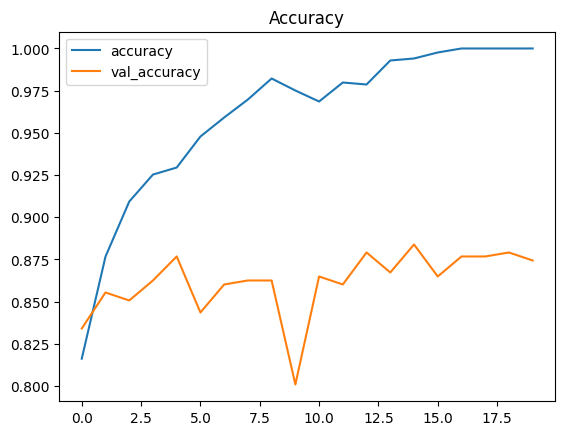

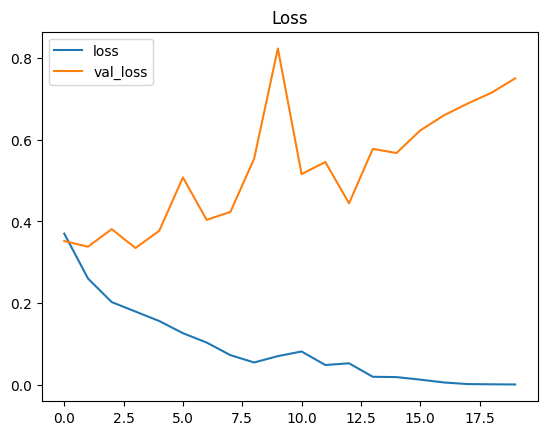

In [15]:
pd.DataFrame(historia.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

pd.DataFrame(historia.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

In [16]:
resultados = modelo.evaluate(test_gen, verbose=0)
print(f'Test Loss: {resultados[0]}')
print(f'Test Accuracy: {resultados[1]}')

Test Loss: 0.7498554587364197
Test Accuracy: 0.8744075894355774


## Predecir etiqueta

In [17]:
prediccion = modelo.predict(test_gen)
prediccion = np.argmax(prediccion, axis=1)
etiquetas = (train_gen.class_indices)
etiquetas = dict((v, k) for k, v in etiquetas.items())
prediccion = [etiquetas[k] for k in prediccion]

14/14 [==============================] - 4s 200ms/step


In [18]:
y_test = list(test.Etiqueta) #Nombre de columna "Etiqueta"
print(classification_report(y_test, prediccion))

              precision    recall  f1-score   support

     benigno       0.89      0.88      0.89       233
     maligno       0.85      0.87      0.86       189

    accuracy                           0.87       422
   macro avg       0.87      0.87      0.87       422
weighted avg       0.87      0.87      0.87       422



In [ ]:
fig, axes = plt.subplots(nrows=round(len(test.Ruta)/2), ncols=2, figsize=(12,8), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Ruta.iloc[i]))
    ax.set_title(f'Verdadero: {test.Etiqueta.iloc[i]}\nPredicted: {prediccion[i]}')
plt.tight_layout()
plt.show()

## Eliminar carpetas

In [20]:
#%cd /content/dataset
#!rm -rf 'maligno'
#!rm -rf 'dataset'
#!rm -rf 'train'
#!rm -rf 'test'